<a href="https://colab.research.google.com/github/minkyung172/2022_ML_study_winter/blob/main/ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [43]:
data = pd.read_excel('/content/drive/MyDrive/CTX_Demo_n506.xlsx')

In [44]:
data = data.drop(labels = ['GWAS_hos','FAM1', 'FAM2', 'RID', 'RID_no', 'ID', 'Time_PETMRI', 'ABS(Time)', 'Dx'], axis = 1)

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
y = data.loc[:, "111CUTOFF"]

data = data.drop("111CUTOFF", axis = 1)

scaler = StandardScaler()
data_scale = scaler.fit_transform(data)
data_scale = pd.DataFrame(data_scale, index = data.index, columns = data.columns)

In [47]:
X = data_scale

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

names = ['Logistic Regression', 'KNN', 'SVC-linear', 'SVC-RBF', 'SVC-poly', 'Decision Tree']
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    KNeighborsClassifier(n_neighbors=10),
    SVC(kernel="linear", C=1, probability=True),
    SVC(kernel="rbf", C=1, probability=True),
    SVC(kernel="poly", C=1, probability=True),
    DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
]

fit_model = [model.fit(X_train, y_train) for model in models]
preds = [model.predict(X_test) for model in fit_model]

table = pd.DataFrame({
    'Model' : names,
    'Accuracy' : (accuracy_score(y_test, y_pred) for y_pred in preds),
    'Precision':(precision_score(y_test, y_pred) for y_pred in preds),
    'Recall':(recall_score(y_test, y_pred) for y_pred in preds),
    'F1':(f1_score(y_test, y_pred) for y_pred in preds)
})

table

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.705882,0.619048,0.650,0.634146
1,KNN,0.617647,0.526316,0.250,0.338983
2,SVC-linear,0.666667,0.562500,0.675,0.613636
3,SVC-RBF,0.696078,0.636364,0.525,0.575342
4,SVC-poly,0.637255,0.714286,0.125,0.212766
5,Decision Tree,0.686275,0.633333,0.475,0.542857


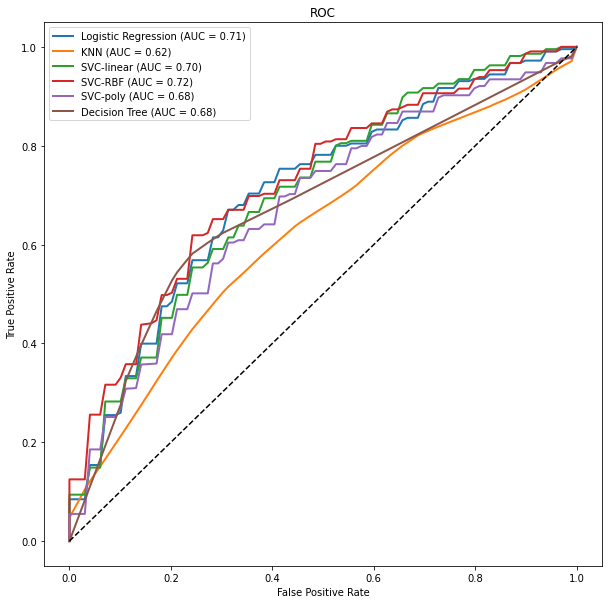

In [50]:
from sklearn.model_selection import StratifiedKFold

plt.figure(figsize=(10,10))
cv = StratifiedKFold(n_splits=10)

res_df = pd.DataFrame([])

for model, name in zip(models, names):
  tprs = []
  mean_fpr = np.linspace(0, 1, 100)

  for train_id, test_id in cv.split(X, y):
    X_train, y_train = X.iloc[train_id,:], y[train_id]
    X_test, y_test = X.iloc[test_id,:], y[test_id]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    table = pd.DataFrame({
      'Model':[name],
      'Accuracy':[accuracy_score(y_test, y_pred)],
      'Precision':[precision_score(y_test, y_pred)],
      'Recall':[recall_score(y_test, y_pred)],
      'F1':[f1_score(y_test, y_pred)],
      'AUC':[roc_auc_score(y_test, y_score)]
    })
    res_df = pd.concat([res_df, table])
  
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)

  plt.plot(np.insert(mean_fpr, 0, 0), np.insert(mean_tpr, 0, 0), 
          label='{} (AUC = {:.2f})'.format(name, mean_auc), lw=2, alpha=1)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()